squeeze:tensor([1, 1])


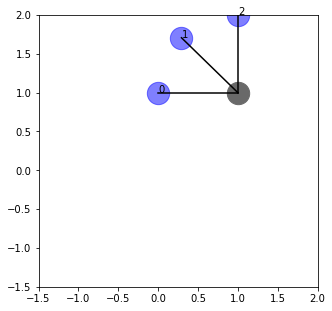

D:\Anaconda3\envs\conv_qsar\lib\site-packages\ipykernel_launcher.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [264]:
# the purpose of this test is to check if the 2D kernel can learn to generate pattern present in the training data
# step 1. test of data with same attributes with the same length
# step 2  test of data with same attributes with the different length
# step 3. test with different attributes  and different length

# data generation
import torch
import matplotlib.pyplot as plt
import math
from torch_geometric.data import Data

# S = 3
x = torch.tensor([[1],[1],[1]], dtype = torch.float)
p = torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1]], dtype = torch.float)



#S = 4
# data
# x = torch.tensor([[1],[1],[1],[1]], dtype = torch.float)
# p = torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1], [math.sqrt(0.5), math.sqrt(0.5)]], dtype = torch.float)

# translate

trans = torch.tensor([[1,1]])
p+=trans

def color_for_element(atomic_num):
    color ='lightgrey'
    if(atomic_num == 1):
        color = 'lightgrey'
    elif(atomic_num ==6):
        color = 'black'
    elif(atomic_num ==8):
        color = 'red'
    elif(atomic_num ==7):
        color = 'blue'
    return color

def vis(p, origin, x = None):
    fig_size = 5
    marker_size = 500
    lower_bound = -1.5
    upper_bound = 2
    
    plt.figure(figsize = (fig_size,fig_size))
    plt.xlim(lower_bound,upper_bound)
    plt.ylim(lower_bound,upper_bound)
    
    if isinstance(p, Data):
        p = p.p

    
    for i in range(p.shape[0]):
        if x is None:
            plt.annotate(i, (p[i,:]))
            color = 'blue'
        else:
            pt = Chem.GetPeriodicTable() 
            atomic_num = int(x[i,0].item())
            plt.annotate(pt.GetElementSymbol(atomic_num),(p[i,:]))
            marker_size = x[i,2].item()*500
            color = color_for_element(atomic_num)
        plt.scatter(p[i,0], p[i,1], color = color, s = marker_size, alpha = 0.5)
        
        
    plt.scatter(origin[0], origin[1], color = 'dimgrey', s= marker_size)
    for each_p in p:
        plt.plot([each_p[0], origin[0]],[each_p[1],origin[1]], color = 'black')
    plt.show()    

print(f'squeeze:{trans.squeeze(dim=0)}')
origin = torch.tensor([0,0]) + trans.squeeze(dim =0)
vis(p, origin)


def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in degrees.
    """
    angle = angle * math.pi/180
    
    ox, oy = origin
#     print(f'ox:{ox}, oy:{oy}')
    px, py = point
#     print(f'px:{px}, py:{py}')
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return torch.tensor([qx, qy])

def tensor_rotate(origin, points, angle):
    l = []
    for point in points:
        new_p = rotate(origin, point, angle)
        l.append(new_p)
    l = torch.stack(l, dim=0)
#     print(f'f:{l.shape}')
    return torch.tensor(l)
        
new_p = tensor_rotate(origin, p, 180)
# print(new_p)
# vis(new_p, origin)

data_list = []
for i in range(0, 370, 10):
    new_p = tensor_rotate(origin, p, i)
    data = Data(p = new_p, origin = origin)
    data_list.append(data)

# for data in data_list:
#     vis(data, origin)


In [136]:
# conv
from torch_geometric.nn import MessagePassing
from torch.nn import CosineSimilarity
from torch.nn import Linear, Sigmoid
from torch.nn import Module
from itertools import permutations
from torch.nn.parameter import Parameter


# kernel = Data(p_s = p_s)
# same_kernel = Data(p_s = p)
sig = Sigmoid()

def permute(x):
    rows = x.shape[0]
    l = [x[torch.tensor(permute)] for permute in list(permutations(range(rows)))]
    return l

class Kernel(Module):
    def __init__(self, init_kernel=None, S = 3):
        super(Kernel, self).__init__()
        if init_kernel is None:
            if S is None:
                raise Exception('S is not specified')
            else:
                init_kernel = Data(p_s = torch.randn(S,2))
#             print(init_kernel.p_s)
        p_s_tensor = init_kernel.p_s#torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1]], dtype = torch.float)
        p_s = Parameter(p_s_tensor)
        self.p_s = p_s
        
    def self_sim(self,p):
        cos = CosineSimilarity(dim = 1)
#         for i in p.shape[0]
        new_p = torch.roll(p,1,0)
#         print('\n')
#         print(f'p:{p}')
#         print(f'new_p:{new_p}')
        sc = cos(new_p, p)
#         print(f'sc:{sc}')
        return sc
    
    def sim(self, p, p_s):
        cos = CosineSimilarity(dim = 0)
#         print('p_dist:')
        inter_p_dist = self.self_sim(p)
#         print('\n')
#         print('s_dist:')
        inter_p_s_dist = self.self_sim(p_s)
#         print(f'inter_p_s_dist:{inter_p_s_dist}')
        sc = cos(inter_p_dist, inter_p_s_dist)
#         sc = torch.dot(inter_p_dist, inter_p_s_dist.T)
#         print(sc)
        return sc

    def length_sim(self, p, p_s):
        len_p = torch.norm(p, dim = -1)
        len_p_s = torch.norm(p_s, dim = -1)
        print(len_p.shape)
        
        # cos similarity
        cos = CosineSimilarity(dim = 0)
        sc = cos(len_p,len_p_s)
        
        # dot product similarity
#         act = Sigmoid()
#         sc = act(torch.sum(p*p_s))

        # inverse of l1 norm
        diff = len_p - len_p_s
        sc = 1/diff
    
        # inverse of L2 norm
        diff = torch.square(len_p - len_p_s)
        sc = torch.sum(diff)
        sc = torch.atan(1/sc)
    
#         print(sc)
        return sc
    
    def forward(self, data):
        score=0
        p = data.p - data.origin
        p_s = self.p_s
        
        p_s_list = permute(p_s)
#         print(f'permute len:{len(p_s_list)}')
    
        
        max_angle_sc = torch.tensor(-float('Inf'))
        max_index = 0
        for i, each_p_s in enumerate(p_s_list):
#             print('\n')
#             print(f'i:{i}')
#             print(f'each_p_s:\n{each_p_s}')
#             print(f'p:\n{p}')
            angle_sc = self.sim(p, each_p_s)
#             print(f'{i} angle_sc:{angle_sc}, max_angle_sc:{max_angle_sc}, max_index:{max_index}')
            if angle_sc > max_angle_sc:
                max_index = i
                max_angle_sc = angle_sc
        
        # get the p and p_s combination that gives the best angle score
        best_p_s = p_s_list[max_index]
        length_sc = self.length_sim(p, best_p_s)
        
        length_sc = length_sc.unsqueeze(dim = 0)
        max_angle_sc = max_angle_sc.unsqueeze(dim = 0)
        
#         print(length_sc.shape)
#         print(max_angle_sc.shape)
        
        one = torch.tensor([math.pi/2])
        
        sc = torch.atan(1/(torch.square(length_sc-one) + torch.square(max_angle_sc-one)))

        print(f'len sc:{length_sc}, angle sc:{max_angle_sc}, total sc: {sc}')
        return sc
        

# class Graph3DConv(MessagePassing):
#     def __init__(self, kernel):
#         super(Graph3DConv, self).__init__()
#         self.kernel = kernel
# #         self.lin = Linear(3,2)
    

            
        
#     def message(self):
#         pass



# data = data_list[0]

# print('less similar')
# p_s = torch.tensor([[5,0],[-math.sqrt(2.5),-math.sqrt(2.5)],[0,5]], dtype = torch.float)
# kernel = Data(p_s = p_s)
# model = Kernel(kernel)
# out = model(data)
# # print(out)

# print('\n')
# print('less similar')
# p_s = torch.tensor([[1.5,0],[1.4,0],[0,1.5]], dtype = torch.float)
# kernel = Data(p_s = p_s)
# model = Kernel(kernel)
# out = model(data)

# print('\n')
# print('more similar')
# p_s = torch.tensor([[1.3,0],[1.2,0],[0,1.0]], dtype = torch.float)
# kernel = Data(p_s = p_s)
# model = Kernel(kernel)
# out = model(data)


# print('\n')
# print('length same')
# p_s = torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1]], dtype = torch.float)
# kernel = Data(p_s = p_s)
# model = Kernel(kernel)
# out = model(data)

# print('\n')
# print('totally same')
# kernel = Data(p_s = (p-origin))
# model = Kernel(kernel)
# out = model(data)


1-0 angle:163.0965982094954
2-0 angle:136.52396580961425
2-1 angle:60.37941184785715


0 length:1.4286112785339355
1 length:2.205396890640259
2 length:2.447592258453369
torch.Size([3])
len sc:tensor([0.261789], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([-0.126006], grad_fn=<UnsqueezeBackward0>), total sc: tensor([0.214393], grad_fn=<AtanBackward>)


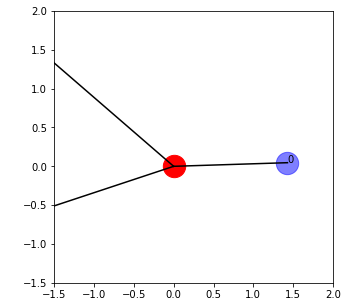

In [235]:
# reset kernel and check kernel before training
import numpy as np
def angle_between_two_vectors(vector_1, vector_2):

#     print('\n')
#     print('vector1:')
#     print(vector_1)
#     print('vector2:')
#     print(vector_2)
    
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
#     print('norm vector1:')
#     print(unit_vector_1)
    
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
#     print('norm vector2:')
#     print(unit_vector_2)
    
    dot_product = np.dot(unit_vector_1, unit_vector_2)
#     print(f'dot:{dot_product}')
    angle = np.arccos(dot_product)
    angle = angle/math.pi *180
    return angle

def edge_length(vector):
    return np.linalg.norm(vector)

p_s_origin = torch.tensor([0,0])
# S = 3
S = 3
x_c = torch.tensor([[1]], dtype = torch.float)
x_s = torch.tensor([[1],[1],[1]], dtype = torch.float)
p_s = torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1]], dtype = torch.float)

# # S = 4
# # kernel
# S = 4
# x_c = torch.tensor([[1]], dtype = torch.float)
# x_s = torch.tensor([[1],[1],[1]], dtype = torch.float)
# p_s = torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1], [math.sqrt(0.5), -math.sqrt(0.5)]], dtype = torch.float)

kernel = Data(p_s = p_s)
model = Kernel(kernel)
# randomize kernel
model = Kernel(S =S)
params = model.parameters()
param = list(params)[0].detach().numpy()

for i in range(S):
    for j in range(i):
        print(f'{i}-{j} angle:{angle_between_two_vectors(param[i], param[j])}')
print('\n')
for i in range(S):
    print(f'{i} length:{edge_length(param[i])}')


output_kernel = Data(p_s = torch.tensor(param))
output_model = Kernel(output_kernel)
out = output_model(data)

vis(param, p_s_origin)

In [142]:
# training without attributed data
from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
import random

torch.set_printoptions(precision=6)
random.seed(None)
optimizer = Adam(model.parameters(), lr=0.01)  # Define optimizer.

# Loss func selection
criterion = MSELoss()
# criterion = CosineSimilarity(dim = 0)
# criterion = CrossEngropyLoss

def train():
    random.shuffle(data_list)
    for data in data_list:
        out = model(data)
        label = torch.tensor(math.pi/2, dtype= torch.float)
#         print(out)
        loss = criterion(out, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#     print(loss)

for i in range(20):
    print(f'epoch {i}')
    train()
    
    # turn on this to visulize each step
#     params = model.parameters()
#     param = list(params)[0].detach().numpy()
#     vis(param, p_s_origin)
    


epoch 0
torch.Size([3])
len sc:tensor([0.995990], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.002069], grad_fn=<UnsqueezeBackward0>), total sc: tensor([0.344010], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.012256], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.002836], grad_fn=<UnsqueezeBackward0>), total sc: tensor([0.346396], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.028298], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.003725], grad_fn=<UnsqueezeBackward0>), total sc: tensor([0.348769], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.044083], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.004739], grad_fn=<UnsqueezeBackward0>), total sc: tensor([0.351126], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.059596], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.005884], grad_fn=<UnsqueezeBackward0>), total sc: tensor([0.353470], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.074836], grad_fn=<UnsqueezeBackwar

torch.Size([3])
len sc:tensor([1.453177], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.627931], grad_fn=<UnsqueezeBackward0>), total sc: tensor([0.836420], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.455736], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.652791], grad_fn=<UnsqueezeBackward0>), total sc: tensor([0.862845], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.458265], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.677257], grad_fn=<UnsqueezeBackward0>), total sc: tensor([0.889338], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.460732], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.701176], grad_fn=<UnsqueezeBackward0>), total sc: tensor([0.915651], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.463114], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.724395], grad_fn=<UnsqueezeBackward0>), total sc: tensor([0.941531], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.465396], grad_fn=<UnsqueezeBackward0>), an

len sc:tensor([1.511493], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999469], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.252110], grad_fn=<AtanBackward>)
epoch 3
torch.Size([3])
len sc:tensor([1.512624], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999513], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.252275], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.513763], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999552], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.252434], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.514907], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999589], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.252589], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.516051], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999623], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.252738], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.517194], grad_fn=<UnsqueezeBackward0>), angle sc:t

len sc:tensor([1.548664], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999974], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255364], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.548877], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999975], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255373], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.549084], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999976], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255382], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.549287], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999976], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255391], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.549486], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999977], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255400], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.549680], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0

epoch 6
torch.Size([3])
len sc:tensor([1.556515], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999997], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255646], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.556614], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999997], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255648], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.556711], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999997], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255651], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.556808], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999997], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255653], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.556903], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999997], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255656], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.556997], grad_fn=<UnsqueezeBackwar

torch.Size([3])
len sc:tensor([1.560681], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999999], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255740], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.560736], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999999], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255741], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.560791], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999999], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255742], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.560845], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999999], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255743], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.560899], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999999], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255744], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.560952], grad_fn=<UnsqueezeBackward0>), an

len sc:tensor([1.563078], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999999], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255779], grad_fn=<AtanBackward>)
epoch 9
torch.Size([3])
len sc:tensor([1.563114], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255780], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.563149], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255780], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.563184], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255780], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.563218], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255781], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.563252], grad_fn=<UnsqueezeBackward0>), angle sc:t

len sc:tensor([1.564713], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255800], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.564737], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255800], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.564761], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255800], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.564784], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255800], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.564808], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255801], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.564831], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1

torch.Size([3])
len sc:tensor([1.565850], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255811], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.565867], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255811], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.565884], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255811], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.565901], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255812], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.565917], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255812], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.565934], grad_fn=<UnsqueezeBackward0>), an

len sc:tensor([1.566665], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255818], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.566678], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255818], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.566691], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255818], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.566703], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255818], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.566716], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255818], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.566728], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.00000

len sc:tensor([1.567304], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255822], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.567314], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255822], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.567323], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255822], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.567333], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255823], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.567343], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255823], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.567352], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBa

len sc:tensor([1.567783], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255825], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.567790], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255825], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.567798], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255825], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.567806], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255825], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.567813], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255825], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.567821], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward

torch.Size([3])
len sc:tensor([1.568165], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255827], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.568171], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255827], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.568177], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255827], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.568184], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255827], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.568190], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255827], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.568196], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad

len sc:tensor([1.568476], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255829], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.568481], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255829], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.568486], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255829], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.568491], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255829], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.568496], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255829], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.568501], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], gr

[[ 0.79312474 -0.55427074]
 [ 0.18009672 -1.0169156 ]
 [ 0.9947687   0.17619662]]
1-0 angle:45.009437158577455
2-0 angle:44.9917981950459
2-1 angle:90.00123876871794


0 length:0.967606782913208
1 length:1.0327401161193848
2 length:1.0102524757385254
torch.Size([3])
len sc:tensor([1.568570], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255829], grad_fn=<AtanBackward>)


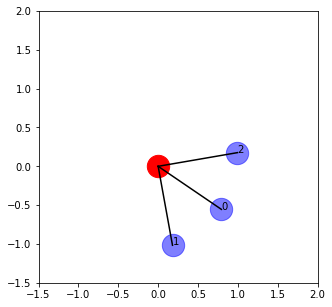

In [143]:
# visualize kernel in the model without attributed data

params = model.parameters()
param = list(params)[0].detach().numpy()
print(param)



# print('param[0]:')
# print(param[0])
# print('param[1]:')
# print(param[1])
# print('param[2]:')
# print(param[2])

for i in range(S):
    for j in range(i):
        print(f'{i}-{j} angle:{angle_between_two_vectors(param[i], param[j])}')
print('\n')
for i in range(S):
    print(f'{i} length:{edge_length(param[i])}')

output_kernel = Data(p_s = torch.tensor(param))
output_model = Kernel(output_kernel)
out = output_model(data)



vis(param, p_s_origin)



calculating rdkit element representation lookup table
tensor([[ 1.299038e+00,  7.500000e-01],
        [-1.299038e+00,  7.500000e-01],
        [-2.775558e-16, -1.500000e+00]])
tensor([-5.551115e-17, -5.551115e-17])
tensor([[ 8.000000, 15.999000,  1.550000,  2.000000,  6.000000],
        [ 1.000000,  1.008000,  1.200000,  1.000000,  1.000000],
        [ 1.000000,  1.008000,  1.200000,  1.000000,  1.000000]])
Data(origin=[2], p=[3, 2], x=[3, 5])


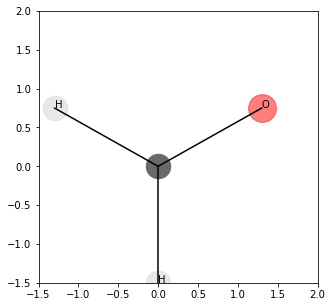

D:\Anaconda3\envs\conv_qsar\lib\site-packages\ipykernel_launcher.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [277]:
# test of p with different attributes
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit

elements = ['H', 'C', 'N', 'O', 'P', 'S', 'F', 'Cl', 'Br', 'I']
elem_lst =None


def lookup_from_rdkit(elements):
	global elem_lst

	if elem_lst is None:
		print('calculating rdkit element representation lookup table')
		elem_rep_lookup = []
		for elem in elements:
			pt = Chem.GetPeriodicTable() 
			
			if isinstance(elem, int):
				num=elem
				sym=pt.GetElementSymbol(num)
			else:
				num = pt.GetAtomicNumber(elem)
				sym = elem
			w = pt.GetAtomicWeight(elem)
			
			Rvdw = pt.GetRvdw(elem)
		#     Rcoval = pt.GetRCovalent(elem)
			valence = pt.GetDefaultValence(elem)
			outer_elec = pt.GetNOuterElecs(elem)



			elem_rep=[num, w,  Rvdw, valence, outer_elec]
	#         print(elem_rep)


			elem_rep_lookup.append(elem_rep)
		elem_lst = elem_rep_lookup.copy()
		return elem_rep_lookup
	else:
		return elem_lst




def get_atom_rep(atomic_num, package):
	'''use rdkit or pymatgen to generate atom representation
	'''
	max_elem_num = 118
	element_nums= [x+1 for x in range(max_elem_num)]


	if package =='rdkit':
		elem_lst = lookup_from_rdkit(element_nums)
	elif package == 'pymatgen':
		elem_lst = lookup_from_pymatgen(element_nums)
	else:
		raise Exception('cannot generate atom representation lookup table')
		
	result = 0
	try:
		result = elem_lst[atomic_num - 1]
	except:
		print(f'error: atomic_num {atomic_num} does not exist')


	return result


smiles = 'C(=O)([H])[H]'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# for 3D
# AllChem.EmbedMolecule(mol)
# AllChem.UFFOptimizeMolecule(mol)
# conf = mol.GetConformer()

# for 2D
rdkit.Chem.rdDepictor.Compute2DCoords(mol)
conf = mol.GetConformer()
atom_pos = []
atom_attr =[]
for i, atom in enumerate(mol.GetAtoms()):
    atomic_num = atom.GetAtomicNum()
    h = get_atom_rep(atomic_num, 'rdkit')
    if atomic_num == 6:
        origin = torch.tensor([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z ])
    else:
        atom_pos.append([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z])
        atom_attr.append(h)
                              
p = torch.tensor(atom_pos)
x = torch.tensor(atom_attr)                              

print(p)
print(origin)
print(x)
                            
data = Data(p=p, x=x, origin= origin)
print(data)
vis(data.p, data.origin, x)

data_list = []
for i in range(0, 370, 10):
    new_p = tensor_rotate(origin, p, i)
    data = Data(p = new_p, origin = origin)
    data_list.append(data)



In [288]:
# conv with attributes
from torch_geometric.nn import MessagePassing
from torch.nn import CosineSimilarity
from torch.nn import Linear, Sigmoid
from torch.nn import Module
from itertools import permutations
from torch.nn.parameter import Parameter


# kernel = Data(p_s = p_s)
# same_kernel = Data(p_s = p)
sig = Sigmoid()

def permute(x):
    rows = x.shape[0]
    l = [x[torch.tensor(permute)] for permute in list(permutations(range(rows)))]
    return l

class Kernel(Module):
    def __init__(self, init_kernel=None, S = 3, dim=5):
        super(Kernel, self).__init__()
        print('here')
        print(init_kernel)
        if init_kernel is None:
            print('here')
            if S is None or dim is None:
                raise Exception('S or dim is not specified')
            else:
                
                init_kernel = Data(p_s = torch.randn(S,2), x_s = torch.randn(S,dim))
#             print(init_kernel.p_s)

        p_s_tensor = init_kernel.p_s#torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1]], dtype = torch.float)
        p_s = Parameter(p_s_tensor)
        self.p_s = p_s
        
        x_s_tensor = init_kernel.x_s
        x_s = Parameter(x_s_tensor)
        self.x_s = x_s
        
    def self_sim(self,p):
        cos = CosineSimilarity(dim = 1)
#         for i in p.shape[0]
        new_p = torch.roll(p,1,0)
#         print('\n')
#         print(f'p:{p}')
#         print(f'new_p:{new_p}')
        sc = cos(new_p, p)
#         print(f'sc:{sc}')
        return sc
    
    def sim(self, p, p_s):
        cos = CosineSimilarity(dim = 0)
#         print('p_dist:')
        inter_p_dist = self.self_sim(p)
#         print('\n')
#         print('s_dist:')
        inter_p_s_dist = self.self_sim(p_s)
#         print(f'inter_p_s_dist:{inter_p_s_dist}')
        sc = cos(inter_p_dist, inter_p_s_dist)
#         sc = torch.dot(inter_p_dist, inter_p_s_dist.T)
#         print(sc)
        return sc

    def length_sim(self, p, p_s):
        len_p = torch.norm(p, dim = -1)
        len_p_s = torch.norm(p_s, dim = -1)
        print(len_p.shape)
        
        # cos similarity
        cos = CosineSimilarity(dim = 0)
        sc = cos(len_p,len_p_s)
        
        # dot product similarity
#         act = Sigmoid()
#         sc = act(torch.sum(p*p_s))

        # inverse of l1 norm
        diff = len_p - len_p_s
        sc = 1/diff
    
        # inverse of L2 norm
        diff = torch.square(len_p - len_p_s)
        sc = torch.sum(diff)
        sc = torch.atan(1/sc)
    
#         print(sc)
        return sc
    
    def attribute_sim(self, x, x_s):

        
        # cos similarity
        cos = CosineSimilarity(dim = 0)
        sc = cos(x,x_s)
        
        # dot product similarity
#         act = Sigmoid()
#         sc = act(torch.sum(p*p_s))

        # inverse of l1 norm
        diff = x - x_s
        sc = 1/diff
    
        # inverse of L2 norm
        diff = torch.square(x - x_s)
        sc = torch.sum(diff)
        sc = torch.atan(1/sc)
    
#         print(sc)
        return sc
    
    def forward(self, data):
        score=0
        p = data.p - data.origin
        p_s = self.p_s
        
        p_s_list = permute(p_s)
        x_s_list = permute(x_s)
#         print(f'permute len:{len(p_s_list)}')
    
        
        max_angle_sc = torch.tensor(-float('Inf'))
        max_index = 0
        for i, each_p_s in enumerate(p_s_list):
#             print('\n')
#             print(f'i:{i}')
#             print(f'each_p_s:\n{each_p_s}')
#             print(f'p:\n{p}')
            angle_sc = self.sim(p, each_p_s)
#             print(f'{i} angle_sc:{angle_sc}, max_angle_sc:{max_angle_sc}, max_index:{max_index}')
            if angle_sc > max_angle_sc:
                max_index = i
                max_angle_sc = angle_sc
        
        # get the p and p_s combination that gives the best angle score
        best_p_s = p_s_list[max_index]
        length_sc = self.length_sim(p, best_p_s)

        best_x_s = x_s_list[max_index]
        attr_sc = self.attribute_sim(x, best_x_s)
        
        length_sc = length_sc.unsqueeze(dim = 0)
        max_angle_sc = max_angle_sc.unsqueeze(dim = 0)
        attr_sc = attr_sc.unsqueeze(dim=0)
        
#         print(length_sc.shape)
#         print(max_angle_sc.shape)
        
        one = torch.tensor([math.pi/2])
        
        sc = torch.atan(1/(torch.square(length_sc-one) + torch.square(max_angle_sc-one)+ torch.square(attribute_sc-one)))

        print(f'len sc:{length_sc}, angle sc:{max_angle_sc}, attribute_sc:{attribute_sc} total sc: {sc}')
        return sc
        

# class Graph3DConv(MessagePassing):
#     def __init__(self, kernel):
#         super(Graph3DConv, self).__init__()
#         self.kernel = kernel
# #         self.lin = Linear(3,2)
    

            
        
#     def message(self):
#         pass



# data = data_list[0]

# print('less similar')
# p_s = torch.tensor([[5,0],[-math.sqrt(2.5),-math.sqrt(2.5)],[0,5]], dtype = torch.float)
# kernel = Data(p_s = p_s)
# model = Kernel(kernel)
# out = model(data)
# # print(out)

# print('\n')
# print('less similar')
# p_s = torch.tensor([[1.5,0],[1.4,0],[0,1.5]], dtype = torch.float)
# kernel = Data(p_s = p_s)
# model = Kernel(kernel)
# out = model(data)

# print('\n')
# print('more similar')
# p_s = torch.tensor([[1.3,0],[1.2,0],[0,1.0]], dtype = torch.float)
# kernel = Data(p_s = p_s)
# model = Kernel(kernel)
# out = model(data)


# print('\n')
# print('length same')
# p_s = torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1]], dtype = torch.float)
# kernel = Data(p_s = p_s)
# model = Kernel(kernel)
# out = model(data)

# print('\n')
# print('totally same')
# kernel = Data(p_s = (p-origin))
# model = Kernel(kernel)
# out = model(data)


In [298]:
# reset kernel and check kernel before training with attributed data
import numpy as np
def angle_between_two_vectors(vector_1, vector_2):

#     print('\n')
#     print('vector1:')
#     print(vector_1)
#     print('vector2:')
#     print(vector_2)
    
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
#     print('norm vector1:')
#     print(unit_vector_1)
    
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
#     print('norm vector2:')
#     print(unit_vector_2)
    
    dot_product = np.dot(unit_vector_1, unit_vector_2)
#     print(f'dot:{dot_product}')
    angle = np.arccos(dot_product)
    angle = angle/math.pi *180
    return angle

def edge_length(vector):
    return np.linalg.norm(vector)

p_s_origin = torch.tensor([0,0])
# S = 3
S = 3
x_c = torch.tensor([[1]], dtype = torch.float)
x_s = torch.tensor([[1],[1],[1]], dtype = torch.float)
p_s = torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1]], dtype = torch.float)

# # S = 4
# # kernel
# S = 4
# x_c = torch.tensor([[1]], dtype = torch.float)
# x_s = torch.tensor([[1],[1],[1]], dtype = torch.float)
# p_s = torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1], [math.sqrt(0.5), -math.sqrt(0.5)]], dtype = torch.float)

h_list = []
for i in range(S):
    h = get_atom_rep(8, 'rdkit')
    h_list.append(h)
x_s = torch.tensor(h_list)

kernel = Data(p_s = p_s, x_s = x_s)
model = Kernel(kernel)
# randomize kernel
model = Kernel()
params = model.parameters()
for para in params:
    print(para)

p_s_array = list(params)[0].detach().numpy()
x_s_array = list(params)[1].detach().numpy()

for i in range(S):
    for j in range(i):
        print(f'{i}-{j} angle:{angle_between_two_vectors(param[i], param[j])}')
print('\n')
for i in range(S):
    print(f'{i} length:{edge_length(param[i])}')


output_kernel = Data(p_s = torch.tensor(p_s_array), x_s = torch.tensor(x_s_array))
output_model = Kernel(output_kernel)
out = output_model(data)

vis(param, p_s_origin)

here
Data(p_s=[3, 2], x_s=[3, 5])
here
None
here
Parameter containing:
tensor([[-0.951049,  0.342515],
        [-0.269664, -0.287071],
        [ 0.909355, -2.890570]], requires_grad=True)
Parameter containing:
tensor([[ 0.010923, -0.529182,  0.791857, -1.307705,  0.536885],
        [ 0.256804,  1.094722, -0.004355, -1.573815,  0.084413],
        [-0.923707,  0.067385, -0.234542,  0.381973,  0.078115]],
       requires_grad=True)


IndexError: list index out of range

In [272]:
# training with attributed data
from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
import random

torch.set_printoptions(precision=6)
random.seed(None)
optimizer = Adam(model.parameters(), lr=0.01)  # Define optimizer.

# Loss func selection
criterion = MSELoss()
# criterion = CosineSimilarity(dim = 0)
# criterion = CrossEngropyLoss

def train():
    random.shuffle(data_list)
    for data in data_list:
        out = model(data)
        label = torch.tensor(math.pi/2, dtype= torch.float)
#         print(out)
        loss = criterion(out, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#     print(loss)

for i in range(20):
    print(f'epoch {i}')
    train()
    
    # turn on this to visulize each step
#     params = model.parameters()
#     param = list(params)[0].detach().numpy()
#     vis(param, p_s_origin)
    


epoch 0
torch.Size([3])
len sc:tensor([0.784561], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.333710], grad_fn=<UnsqueezeBackward0>), total sc: tensor([0.435611], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([0.792663], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.347008], grad_fn=<UnsqueezeBackward0>), total sc: tensor([0.443838], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([0.800936], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.360579], grad_fn=<UnsqueezeBackward0>), total sc: tensor([0.452443], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([0.809371], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.374421], grad_fn=<UnsqueezeBackward0>), total sc: tensor([0.461441], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([0.817960], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.388529], grad_fn=<UnsqueezeBackward0>), total sc: tensor([0.470846], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([0.826689], grad_fn=<UnsqueezeBackwar

torch.Size([3])
len sc:tensor([1.270911], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.991632], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.168619], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.278498], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.993170], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.173942], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.285814], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.994460], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.178810], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.292853], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.995535], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.183260], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.299614], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.996427], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.187328], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.306099], grad_fn=<UnsqueezeBackward0>), an

len sc:tensor([1.446579], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999863], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.241808], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.447806], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999872], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.242089], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.449011], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999882], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.242363], grad_fn=<AtanBackward>)
epoch 3
torch.Size([3])
len sc:tensor([1.450195], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999890], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.242629], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.451358], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999898], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.242887], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.452501], grad_fn=<UnsqueezeBackward0>), angle sc:t

len sc:tensor([1.493764], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999996], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.250474], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.494315], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999996], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.250551], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.494861], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999996], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.250625], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.495400], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999996], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.250699], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.495932], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999996], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.250771], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.496459], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0

len sc:tensor([1.516693], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999999], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.253188], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.517002], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999999], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.253218], grad_fn=<AtanBackward>)
epoch 6
torch.Size([3])
len sc:tensor([1.517310], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999999], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.253248], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.517614], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999999], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.253277], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.517915], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999999], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.253306], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.518214], grad_fn=<UnsqueezeBackward0>), angle sc:t

len sc:tensor([1.530463], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999999], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.254363], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.530655], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.254377], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.530846], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.254391], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.531036], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.254404], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.531224], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0.999999], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.254418], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.531411], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([0

len sc:tensor([1.539075], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.254924], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.539206], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.254931], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.539336], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.254939], grad_fn=<AtanBackward>)
epoch 9
torch.Size([3])
len sc:tensor([1.539465], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.254946], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.539593], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.254953], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.539721], grad_fn=<UnsqueezeBackward0>), angle sc:t

torch.Size([3])
len sc:tensor([1.545347], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255248], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.545439], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255252], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.545530], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255256], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.545621], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255260], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.545711], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255265], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.545801], grad_fn=<UnsqueezeBackward0>), an

len sc:tensor([1.549707], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255431], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.549775], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255434], grad_fn=<AtanBackward>)
epoch 12
torch.Size([3])
len sc:tensor([1.549843], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255436], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.549910], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255439], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.549977], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255442], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.550044], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_

len sc:tensor([1.552933], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255545], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.552986], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255547], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.553038], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255548], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.553089], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255550], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.553141], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255552], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.553192], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=

torch.Size([3])
len sc:tensor([1.555603], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255625], grad_fn=<AtanBackward>)
epoch 15
torch.Size([3])
len sc:tensor([1.555644], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255626], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.555684], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255627], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.555724], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255628], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.555764], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255629], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.555804], grad_fn=<UnsqueezeBackward0>), angle sc:te

torch.Size([3])
len sc:tensor([1.557628], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255677], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.557661], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255677], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.557693], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255678], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.557725], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255679], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.557757], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255680], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.557788], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.0

torch.Size([3])
len sc:tensor([1.559259], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255713], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.559285], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255714], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.559311], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255714], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.559337], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255715], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.559363], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255715], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.559389], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.]

torch.Size([3])
len sc:tensor([1.560594], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255739], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.560615], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255740], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.560637], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255740], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.560658], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255740], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.560680], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255741], grad_fn=<AtanBackward>)
torch.Size([3])
len sc:tensor([1.560701], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.], grad

[[ 0.2880428   1.370955  ]
 [ 1.1179998  -1.0017606 ]
 [-1.4257607  -0.46710002]]
1-0 angle:119.99579594277549
2-0 angle:120.00503035853335
2-1 angle:119.9991700562255


0 length:1.4008877277374268
1 length:1.5011489391326904
2 length:1.500325322151184
torch.Size([3])
len sc:tensor([1.560972], grad_fn=<UnsqueezeBackward0>), angle sc:tensor([1.000000], grad_fn=<UnsqueezeBackward0>), total sc: tensor([1.255746], grad_fn=<AtanBackward>)


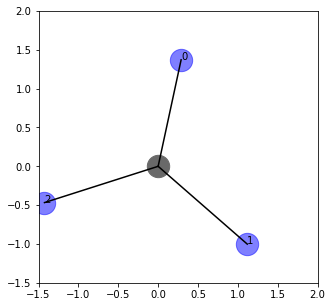

In [273]:
# visualize kernel in the model

params = model.parameters()
param = list(params)[0].detach().numpy()
print(param)



# print('param[0]:')
# print(param[0])
# print('param[1]:')
# print(param[1])
# print('param[2]:')
# print(param[2])

for i in range(S):
    for j in range(i):
        print(f'{i}-{j} angle:{angle_between_two_vectors(param[i], param[j])}')
print('\n')
for i in range(S):
    print(f'{i} length:{edge_length(param[i])}')

output_kernel = Data(p_s = torch.tensor(param))
output_model = Kernel(output_kernel)
out = output_model(data)



vis(param, p_s_origin)

